In [2]:
#this cell written by Celine

#scraping Yahoo Finance for Historical Stock data

#import libraries used for accessing pages randomly (mimicking human behavior)
from time import sleep
from time import time
from random import randint
from warnings import warn
from IPython.core.display import clear_output
import pickle

import pandas as pd

from requests import get
from bs4 import BeautifulSoup

headers = {"Accept-Language": "en-US, en;q=0.5"}

#an array of 5-tuples: (Company Ticker, Violation Date, Start Date, End Date, Penalty Amount)
violations = pickle.load(open("top_r_vals.p", "rb"))

#a list of dataframes, each corresponding to a violation
dataframes = {}

# For every tuple make new get request
for v in violations:
    
    # Lists to store the scraped data in (for each violation)
    dates = []
    opens = []
    highs = []
    lows = []
    closes = []
    adjcloses = []
    volumes = []

    # Make a get request for daily stock values in the date range specified
    response = get('https://finance.yahoo.com/quote/' + str(v[0]) + 
                   '/history?period1=' + str(v[2]) +
                   '&period2=' + str(v[3]) + 
                   '&interval=1mo&filter=history&frequency=1mo',
                   headers = headers)
    
    print('Scraping for: ' + str(v[0]) + ', ' + str(v[2]) + ', ' + str(v[3]))

    # Pause the loop
    sleep(randint(3,8))

    # Parse the content of the request with BeautifulSoup
    page_html = BeautifulSoup(response.text, 'html.parser')

    # Select all the date rows on page (including dividends)
    date_containers = page_html.find_all('tr', {'class' : ["BdT Bdc($c-fuji-grey-c) Ta(end) Fz(s) Whs(nw)"]})

    # Extract data from individual book container
    for container in date_containers:
        cells = container.find_all('td', {'class' : ["Py(10px) Pstart(10px)"]})
        if len(cells) > 0:
            # The date
            date = container.td.text
            dates.append(date)
            # if the row is not a dividend            
            # The open price
            opn = cells[0].text
            opens.append(opn)
            # The high price
            high = cells[1].text
            highs.append(high)
            # The low price
            low = cells[2].text
            lows.append(low)
            # The close price
            close = cells[3].text
            closes.append(close)
            # The adjusted close price
            adjclose = cells[4].text
            adjcloses.append(adjclose)
            # The volume
            volume = cells[5].text
            volumes.append(volume)
            
    # Make a dataframe for this iteration
    # Each dataframe corresponds to a specific violation
    violation_df = pd.DataFrame({'date': dates,
                              'open': opens,
                              'high': highs,
                              'close': closes,
                              'adjusted close': adjcloses,
                              'volume' : volumes
    })
    
    # Add dataframe to dictionary called dataframes
    dataframes[v] = violation_df

Scraping for: APC, 1343160000, 1500840000
Scraping for: NBL, 1350846000, 1508526000
Scraping for: HES, 1256497200, 1414177200
Scraping for: XOM, 1050174000, 1207854000
Scraping for: COP, 929995200, 1087675200
Scraping for: CVX, 987447600, 1145127600
Scraping for: CMI, 1083528000, 1241208000
Scraping for: XOM, 1430593200, 1588273200
Scraping for: CVX, 1461524400, 1619204400
Scraping for: HON, 1285527600, 1443207600


In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
import time

In [69]:
#this cell written by Celine
#not used

def make_readable_date(unix_date):
    ts = int(unix_date)
    return dt.utcfromtimestamp(ts).strftime('%m-%d-%Y')

make_readable_date(violations[9][3])

'09-25-2015'

In [102]:
#this cell written by Cesar and Celine

from matplotlib.backends.backend_pdf import PdfPages  

def plot_save_data(df, key):
    df = df[:-1]
    y_axis = df['adjusted close'].map(float)
    x_axis = range(len(y_axis))
    fig = plt.figure()
    plt.plot(x_axis, y_axis)
    plt.axvline(x=30)
    
    if key[4] > 1000000000:
        amt = str(int(key[4]/1000000000)) + 'B'
    else:
        amt = str(int(key[4]/1000000)) + 'M'
    
    fig.suptitle(key[0] + ': $' + amt + ' violation')
    plt.xlabel("Months")
    plt.ylabel("Closing Stock Price (U.S. Dollars)")
    
    
    plt.savefig('../visualizations/' + key[0] + '_' + amt + '.png', dpi = 100) 
    plt.show()
    plt.close(fig)

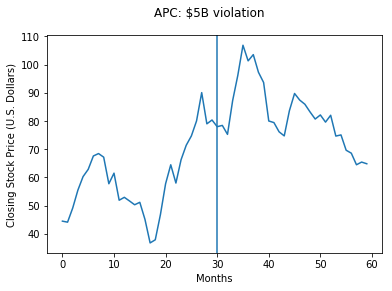

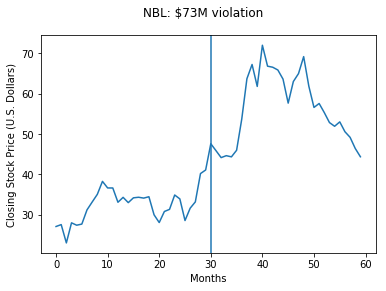

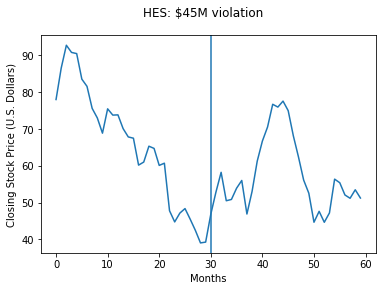

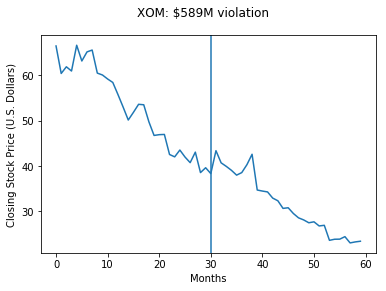

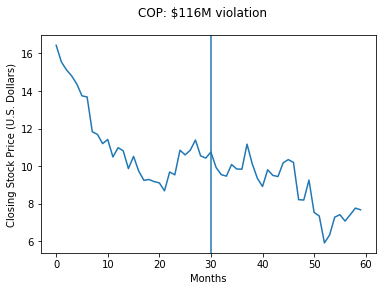

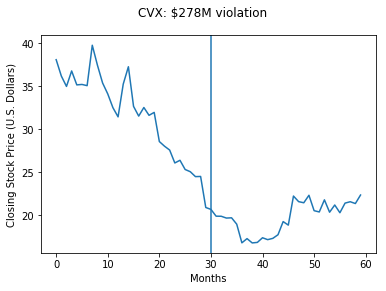

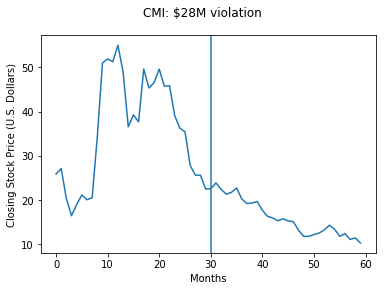

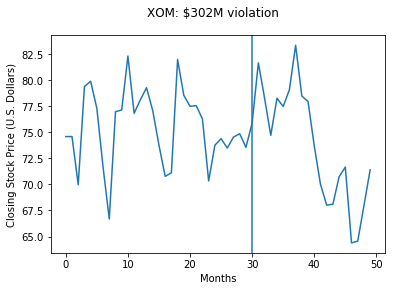

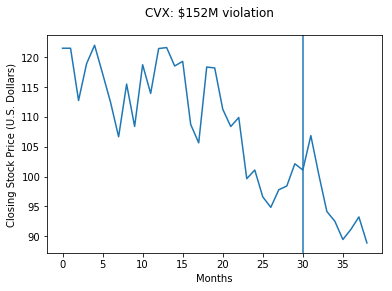

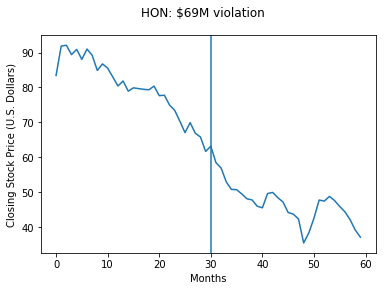

In [103]:
#this cell written by Cesar

for key in dataframes.keys():
    plot_save_data(dataframes[key], key)

In [8]:
#this cell written by Cesar

# get average Y displacement between datapoint and epa_violation_date
adj_close_all = [(key[0], dataframes[key]['adjusted close'][:-1].map(float)) for key in dataframes.keys()]

In [9]:
print(type(adj_close_all[0][1][0]))

<class 'numpy.float64'>


In [10]:
#this cell written by Cesar

def calc_disp(adj_closings):
    epa_violation = adj_closings[29]
    
    left = adj_closings[:29]
    right = adj_closings[31:]
    
    left_sum = sum([epa_violation - val for val in left])
    left_avg = left_sum/len(left)
    
    right_sum = sum([val - epa_violation for val in right])
    right_avg = right_sum/len(right)
    
    return left_avg,right_avg

In [11]:
#this cell written by Celine

for company,closings in adj_close_all:
    b,a = calc_disp(closings)
    if a < b:
        hilo = "LOWER"
    else:
        hilo = "HIGHER"
    print(company + ": Average net change after violation was " + hilo)
    print("\tAverage net change before violation: " + str( "$%.2f" %b))
    print("\tAverage net change after violation: " + str("$%.2f" %a))


APC: Average net change after violation was LOWER
	Average net change before violation: $21.56
	Average net change after violation: $1.97
NBL: Average net change after violation was HIGHER
	Average net change before violation: $8.96
	Average net change after violation: $15.50
HES: Average net change after violation was HIGHER
	Average net change before violation: $-27.52
	Average net change after violation: $18.29
XOM: Average net change after violation was HIGHER
	Average net change before violation: $-13.79
	Average net change after violation: $-8.12
COP: Average net change after violation was LOWER
	Average net change before violation: $-0.99
	Average net change after violation: $-1.63
CVX: Average net change after violation was HIGHER
	Average net change before violation: $-11.20
	Average net change after violation: $-1.17
CMI: Average net change after violation was HIGHER
	Average net change before violation: $-13.68
	Average net change after violation: $-6.59
XOM: Average net cha